# Explore differential expression analysis results

In [60]:
import numpy as np
import anndata
import pandas as pd
import scanpy as sc
import scipy
import re
import pertpy as pt

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
datadir = '/Users/rzhu/Gladstone Dropbox/Ronghui Zhu/GRNPerturbSeq/3_expts/processed_data/CD4iR1_Psomagen/'
experiment_name = 'CD4iR1_Psomagen'

## Reprocess Freimer et al arrayed RNA-seq data with DESeq2

In [104]:
freimer_raw = pd.read_csv('data/Freimer_et_al_raw.csv')

# Convert into anndata
var_df = pd.DataFrame(index=freimer_raw['gene_id'].apply(lambda x: re.sub(r'\.\d+$', '', x)))
var_df.index.name = 'gene_id' # Naming the index of .var
sample_cols = freimer_raw.columns.drop('gene_id')
obs_df = pd.DataFrame(index=sample_cols)
obs_df['donor'] = obs_df.index.map(lambda x: x.split('_')[0] + '_' + x.split('_')[1])
obs_df['sgRNA'] = obs_df.index.map(lambda x: '_'.join(x.split('_')[2:]))
obs_df['target_gene'] = obs_df['sgRNA'].apply(lambda x: "Non-targeting" if "AAVS1" in x else x)
X = freimer_raw[sample_cols].T
X.columns = var_df.index
adata = anndata.AnnData(X=X, obs=obs_df, var=var_df)
adata.var['gene_id'] = adata.var.index

# Perform DESeq2
model = pt.tl.PyDESeq2(adata, design='~ donor + target_gene')
model.fit(quiet=True)

# Extract and parse results
all_res_df = pd.DataFrame()
all_targets = adata.obs['target_gene'].unique().tolist()
all_targets.remove('Non-targeting')
for t in all_targets:
    t_contrast = (model.cond(target_gene = t) - model.cond(target_gene = 'Non-targeting')) 
    res_df = model.test_contrasts(t_contrast)
    res_df['contrast'] = t
    all_res_df = pd.concat([all_res_df, res_df])

all_res_df = all_res_df.reset_index().drop('index', axis=1)

all_dfs = {}
for stat in ['baseMean', 'log_fc', 'lfcSE', 'p_value','adj_p_value']:
    stat_df = all_res_df.pivot(values=stat, columns='variable', index='contrast')
    all_dfs[stat] = stat_df

DE_anndata = anndata.AnnData(
    layers = all_dfs.copy()
)

DE_anndata.obs_names = all_dfs['log_fc'].index.tolist()
DE_anndata.var_names = all_dfs['log_fc'].columns.tolist()
DE_anndata.obs['target_gene'] = DE_anndata.obs_names.values
DE_anndata.var['gene_id'] = DE_anndata.var_names

DE_anndata.write_h5ad('data/Freimer_et_al_DE.h5ad')

## Read best Perturb-seq DE results

In [141]:
adata_de_wdonor = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results.h5ad')
adata_de = adata_de_wdonor[adata_de_wdonor.obs.culture_condition=='Rest'].copy()
# Annotate zscore
adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.obs['target_contrast'].nunique()

## Compare to Freimer et al arrayed RNA-seq

In [228]:
adata_freimer = sc.read_h5ad('dsata/Freimer_et_al_DE.h5ad')
adata_freimer.layers['zscore'] = adata_freimer.layers['log_fc'] / adata_freimer.layers['lfcSE']
common_perturbations = np.intersect1d(adata_freimer.obs.target_gene, adata_de.obs['target_contrast_gene_name'])

In [229]:
thre = 0.05 # Significance threshold
# Only consider perturbations that have >=100 DE genes in either Freimer et al arrayed RNAseq or Perturb-seq dataset
sig_number = np.zeros(len(common_perturbations))
for i, g in enumerate(common_perturbations):
    freimer_set = set(adata_freimer[:,adata_freimer[adata_freimer.obs['target_gene']==g].layers['adj_p_value']<thre].var.gene_id)
    perturbseq_set = set(adata_de[:,adata_de[adata_de.obs['target_contrast_gene_name']==g].layers['adj_p_value']<thre].var.gene_ids)
    sig_number[i] = len(freimer_set | perturbseq_set)
sig_number = sig_number.astype(int)
common_sig_perturbations = common_perturbations[sig_number>=100]

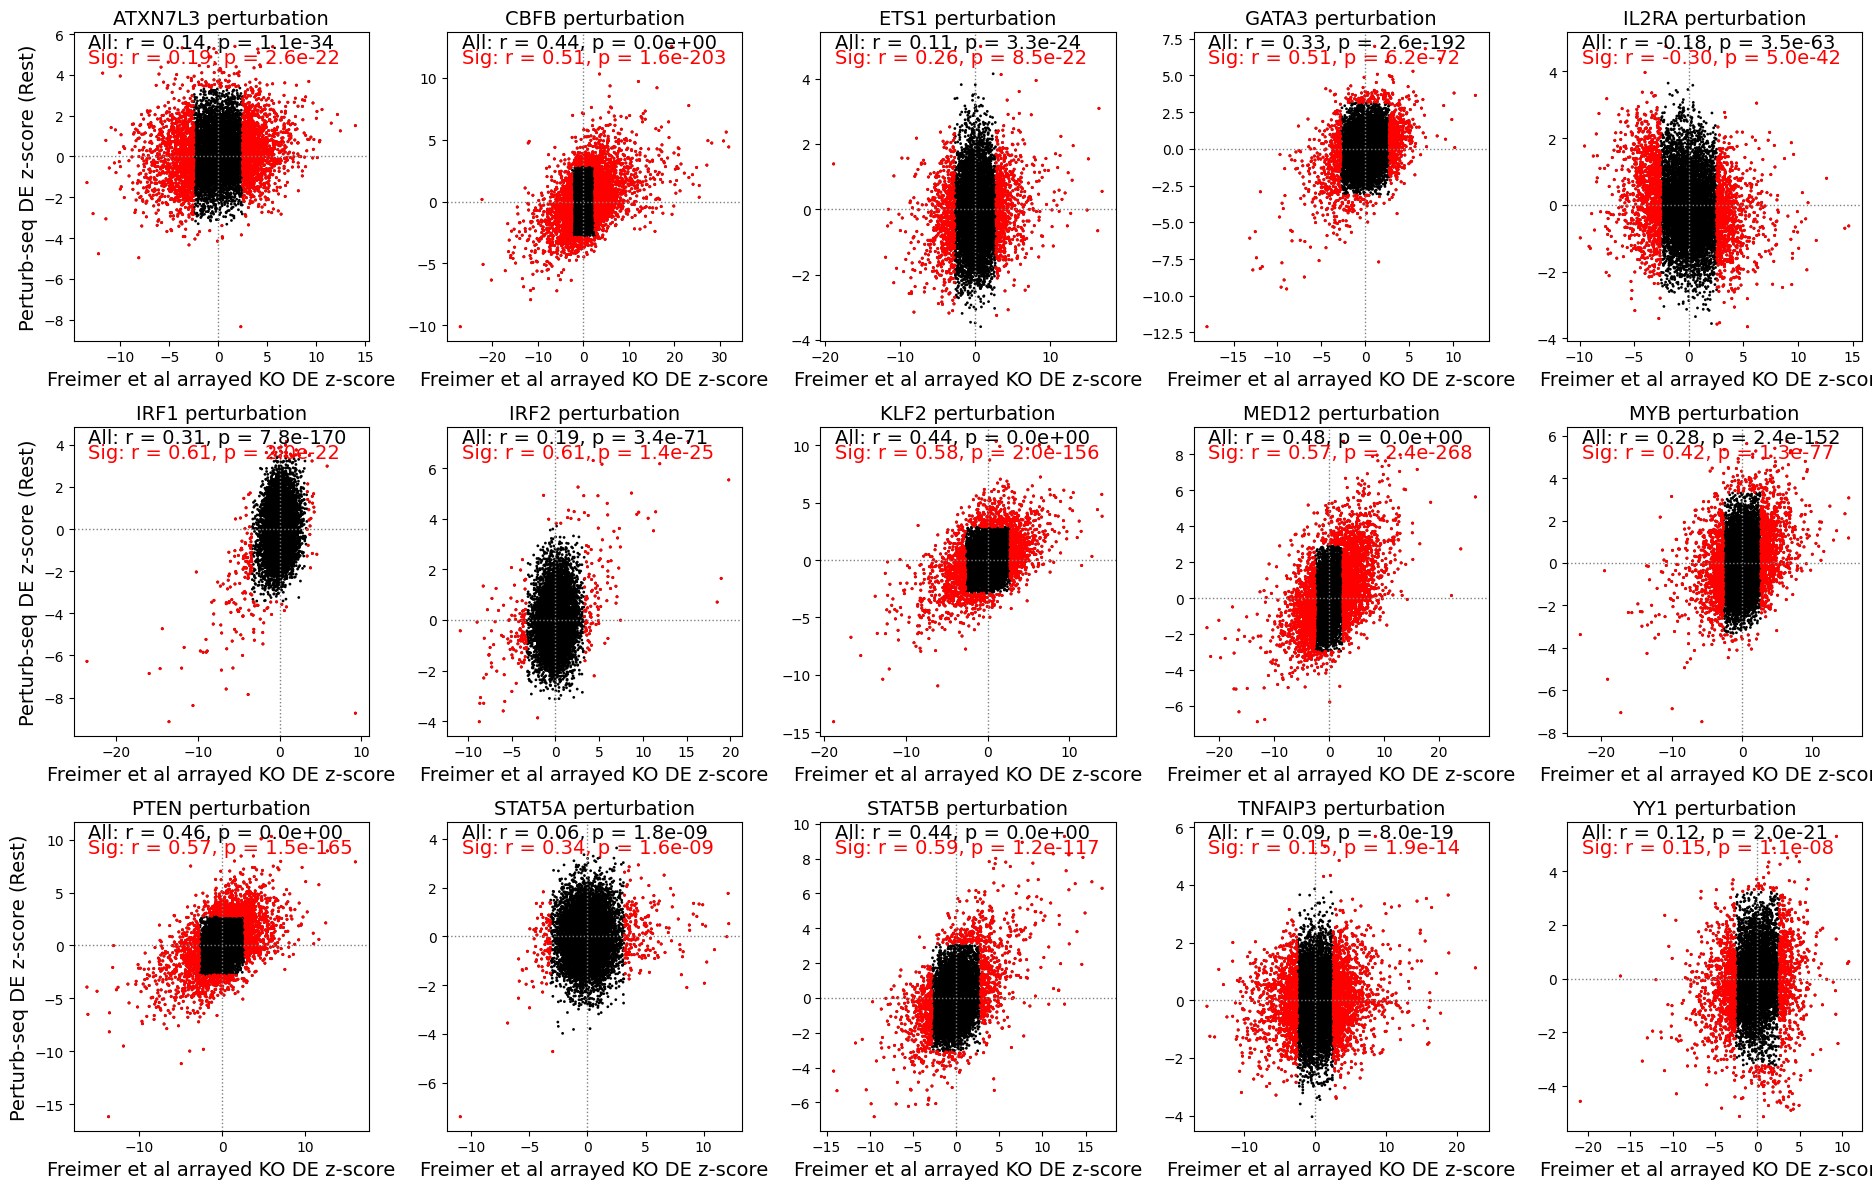

In [230]:
rest_signif_corr_all = np.zeros([len(common_sig_perturbations),2])
gwt_signif = np.zeros(len(common_sig_perturbations))
ko_signif = np.zeros(len(common_sig_perturbations))
# Calculate number of rows and columns needed
n_plots = len(common_sig_perturbations)
n_cols = 5  # Fixed number of columns
n_rows = (n_plots + n_cols - 1) // n_cols  # Ceiling division

# Create a figure with subplots arranged in multiple rows
fig, axes = plt.subplots(n_rows, n_cols, figsize=(19, 4*n_rows))
axes = axes.flatten()  # Flatten to easily iterate through subplots

for i, g in enumerate(common_sig_perturbations):
    # Get data for this perturbation
    gwt_effect_g = sc.get.var_df(adata_de, adata_de.obs_names[adata_de.obs['target_contrast_gene_name'] == g].tolist(), layer='zscore')
    gwt_effect_g.columns = ['perturbseq_zscore']
    gwt_effect_g['perturbseq_signif'] = sc.get.var_df(adata_de, adata_de.obs_names[adata_de.obs['target_contrast_gene_name'] == g].tolist(), layer='adj_p_value')
    freimer_effect_g = sc.get.var_df(adata_freimer, adata_freimer.obs_names[adata_freimer.obs['target_gene'] == g].tolist(), layer='zscore')
    freimer_effect_g.columns = ['freimer_zscore']
    freimer_effect_g['freimer_signif'] = sc.get.var_df(adata_freimer, adata_freimer.obs_names[adata_freimer.obs['target_gene'] == g].tolist(), layer='adj_p_value')

    concat_df = pd.concat([freimer_effect_g, gwt_effect_g], axis=1).dropna()

    # Calculate correlation coefficients and p-values for Rest condition only
    rest_corr, rest_pval = scipy.stats.pearsonr(concat_df['freimer_zscore'], concat_df['perturbseq_zscore'])
    rest_signif_corr, rest_signif_pval = scipy.stats.pearsonr(
        concat_df[(concat_df['freimer_signif']<thre)|(concat_df['perturbseq_signif']<thre)]['freimer_zscore'], 
        concat_df[(concat_df['freimer_signif']<thre)|(concat_df['perturbseq_signif']<thre)]['perturbseq_zscore']
    ) if sum((concat_df['freimer_signif']<thre)|(concat_df['freimer_signif']<thre)) > 1 else (float('nan'), float('nan'))

    # Create scatter plot for Rest condition
    sns.scatterplot(data=concat_df, x='freimer_zscore', y='perturbseq_zscore', s=4, edgecolor='none', color='black', ax=axes[i])
    sns.scatterplot(data=concat_df[(concat_df['freimer_signif']<thre)|(concat_df['perturbseq_signif']<thre)],
                    x='freimer_zscore', y='perturbseq_zscore', s=5, edgecolor='none', color='red', ax=axes[i])

    # Add correlation information as text
    axes[i].annotate(f'All: r = {rest_corr:.2f}, p = {rest_pval:.1e}', 
                xy=(0.05, 0.95), xycoords='axes fraction', fontsize=14)
    if not np.isnan(rest_signif_corr):
        axes[i].annotate(f'Sig: r = {rest_signif_corr:.2f}, p = {rest_signif_pval:.1e}', 
                    xy=(0.05, 0.90), xycoords='axes fraction', fontsize=14, color='red')

    # Add dotted lines for x and y axes
    axes[i].axhline(y=0, color='gray', linestyle=':', linewidth=1)
    axes[i].axvline(x=0, color='gray', linestyle=':', linewidth=1)
    
    # Set title and labels
    axes[i].set_title(f'{g} perturbation', fontsize=14)
    
    # Only add y-label for plots in the first column
    if i % n_cols == 0:
        axes[i].set_ylabel('Perturb-seq DE z-score (Rest)', fontsize=14)
    else:
        axes[i].set_ylabel('')
    
    axes[i].set_xlabel('Freimer et al arrayed KO DE z-score', fontsize=14)

    rest_signif_corr_all[i,0] = rest_signif_corr
    rest_signif_corr_all[i,1] = rest_signif_pval
    gwt_signif[i] = np.sum(concat_df['perturbseq_signif']<thre)
    ko_signif[i] = np.sum(concat_df['freimer_signif']<thre)

# Hide any unused subplots
for i in range(len(common_perturbations), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

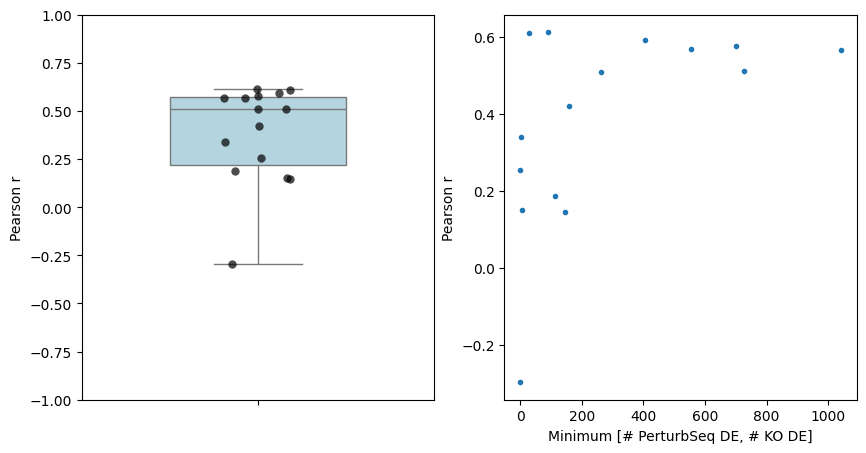

<Figure size 400x600 with 0 Axes>

In [231]:
gwt_signif = gwt_signif.astype(int)
ko_signif = ko_signif.astype(int)
num_signif = pd.DataFrame({'gwt_signif': gwt_signif, 'ko_signif': ko_signif})
# Create a simple DataFrame
df = pd.DataFrame({'r': rest_signif_corr_all[:,0], 'pvalue': rest_signif_corr_all[:,1]})

fig, ax = plt.subplots(1, 2, figsize=(10,5))
# Plot box & stripplot
plt.figure(figsize=(4, 6))
sns.boxplot(data=df, y='r', color='lightblue', width=0.5, ax=ax[0])
sns.stripplot(data=df, y='r', color='black', size=6, jitter=True, alpha=0.7, ax=ax[0])

ax[0].set_ylabel("Pearson r")
ax[0].set_ylim(-1, 1)  # since r ranges from -1 to 1

ax[1].plot(np.min(num_signif, axis=1), rest_signif_corr_all[:,0], '.')
ax[1].set_xlabel('Minimum [# PerturbSeq DE, # KO DE]')
ax[1].set_ylabel('Pearson r')

sns.despine()
plt.tight_layout()
plt.show()

## Compare to Weinstock et al arrayed RNA-seq

In [220]:
weinstock_df = pd.read_csv('data/TableS4_weinstock_et_al_DE.csv')
weinstock_kos = weinstock_df['KO'].unique().tolist()
common_perturbations = np.intersect1d(weinstock_kos, adata_de[adata_de.obs.culture_condition == 'Rest'].obs['target_contrast_gene_name'])
weinstock_df['zscore'] = weinstock_df['log2FoldChange'] / weinstock_df['lfcSE']
weinstock_df['gene_id'] = weinstock_df['gene_id'].str.split('.').str[0]

In [224]:
thre = 0.05 # Significance threshold
# Only consider perturbations that have >=100 DE genes in either Weinstock et al arrayed RNAseq or Perturb-seq dataset
sig_number = np.zeros(len(common_perturbations))
for i, g in enumerate(common_perturbations):
    weinstock_set = set(weinstock_df[(weinstock_df['KO'] == g)&(weinstock_df.padj<thre)].gene_id) 
    perturbseq_set = set(adata_de[:,adata_de[adata_de.obs['target_contrast_gene_name']==g].layers['adj_p_value']<thre].var.gene_ids)
    sig_number[i] = len(weinstock_set | perturbseq_set)
sig_number = sig_number.astype(int)
common_sig_perturbations = common_perturbations[sig_number>=100]

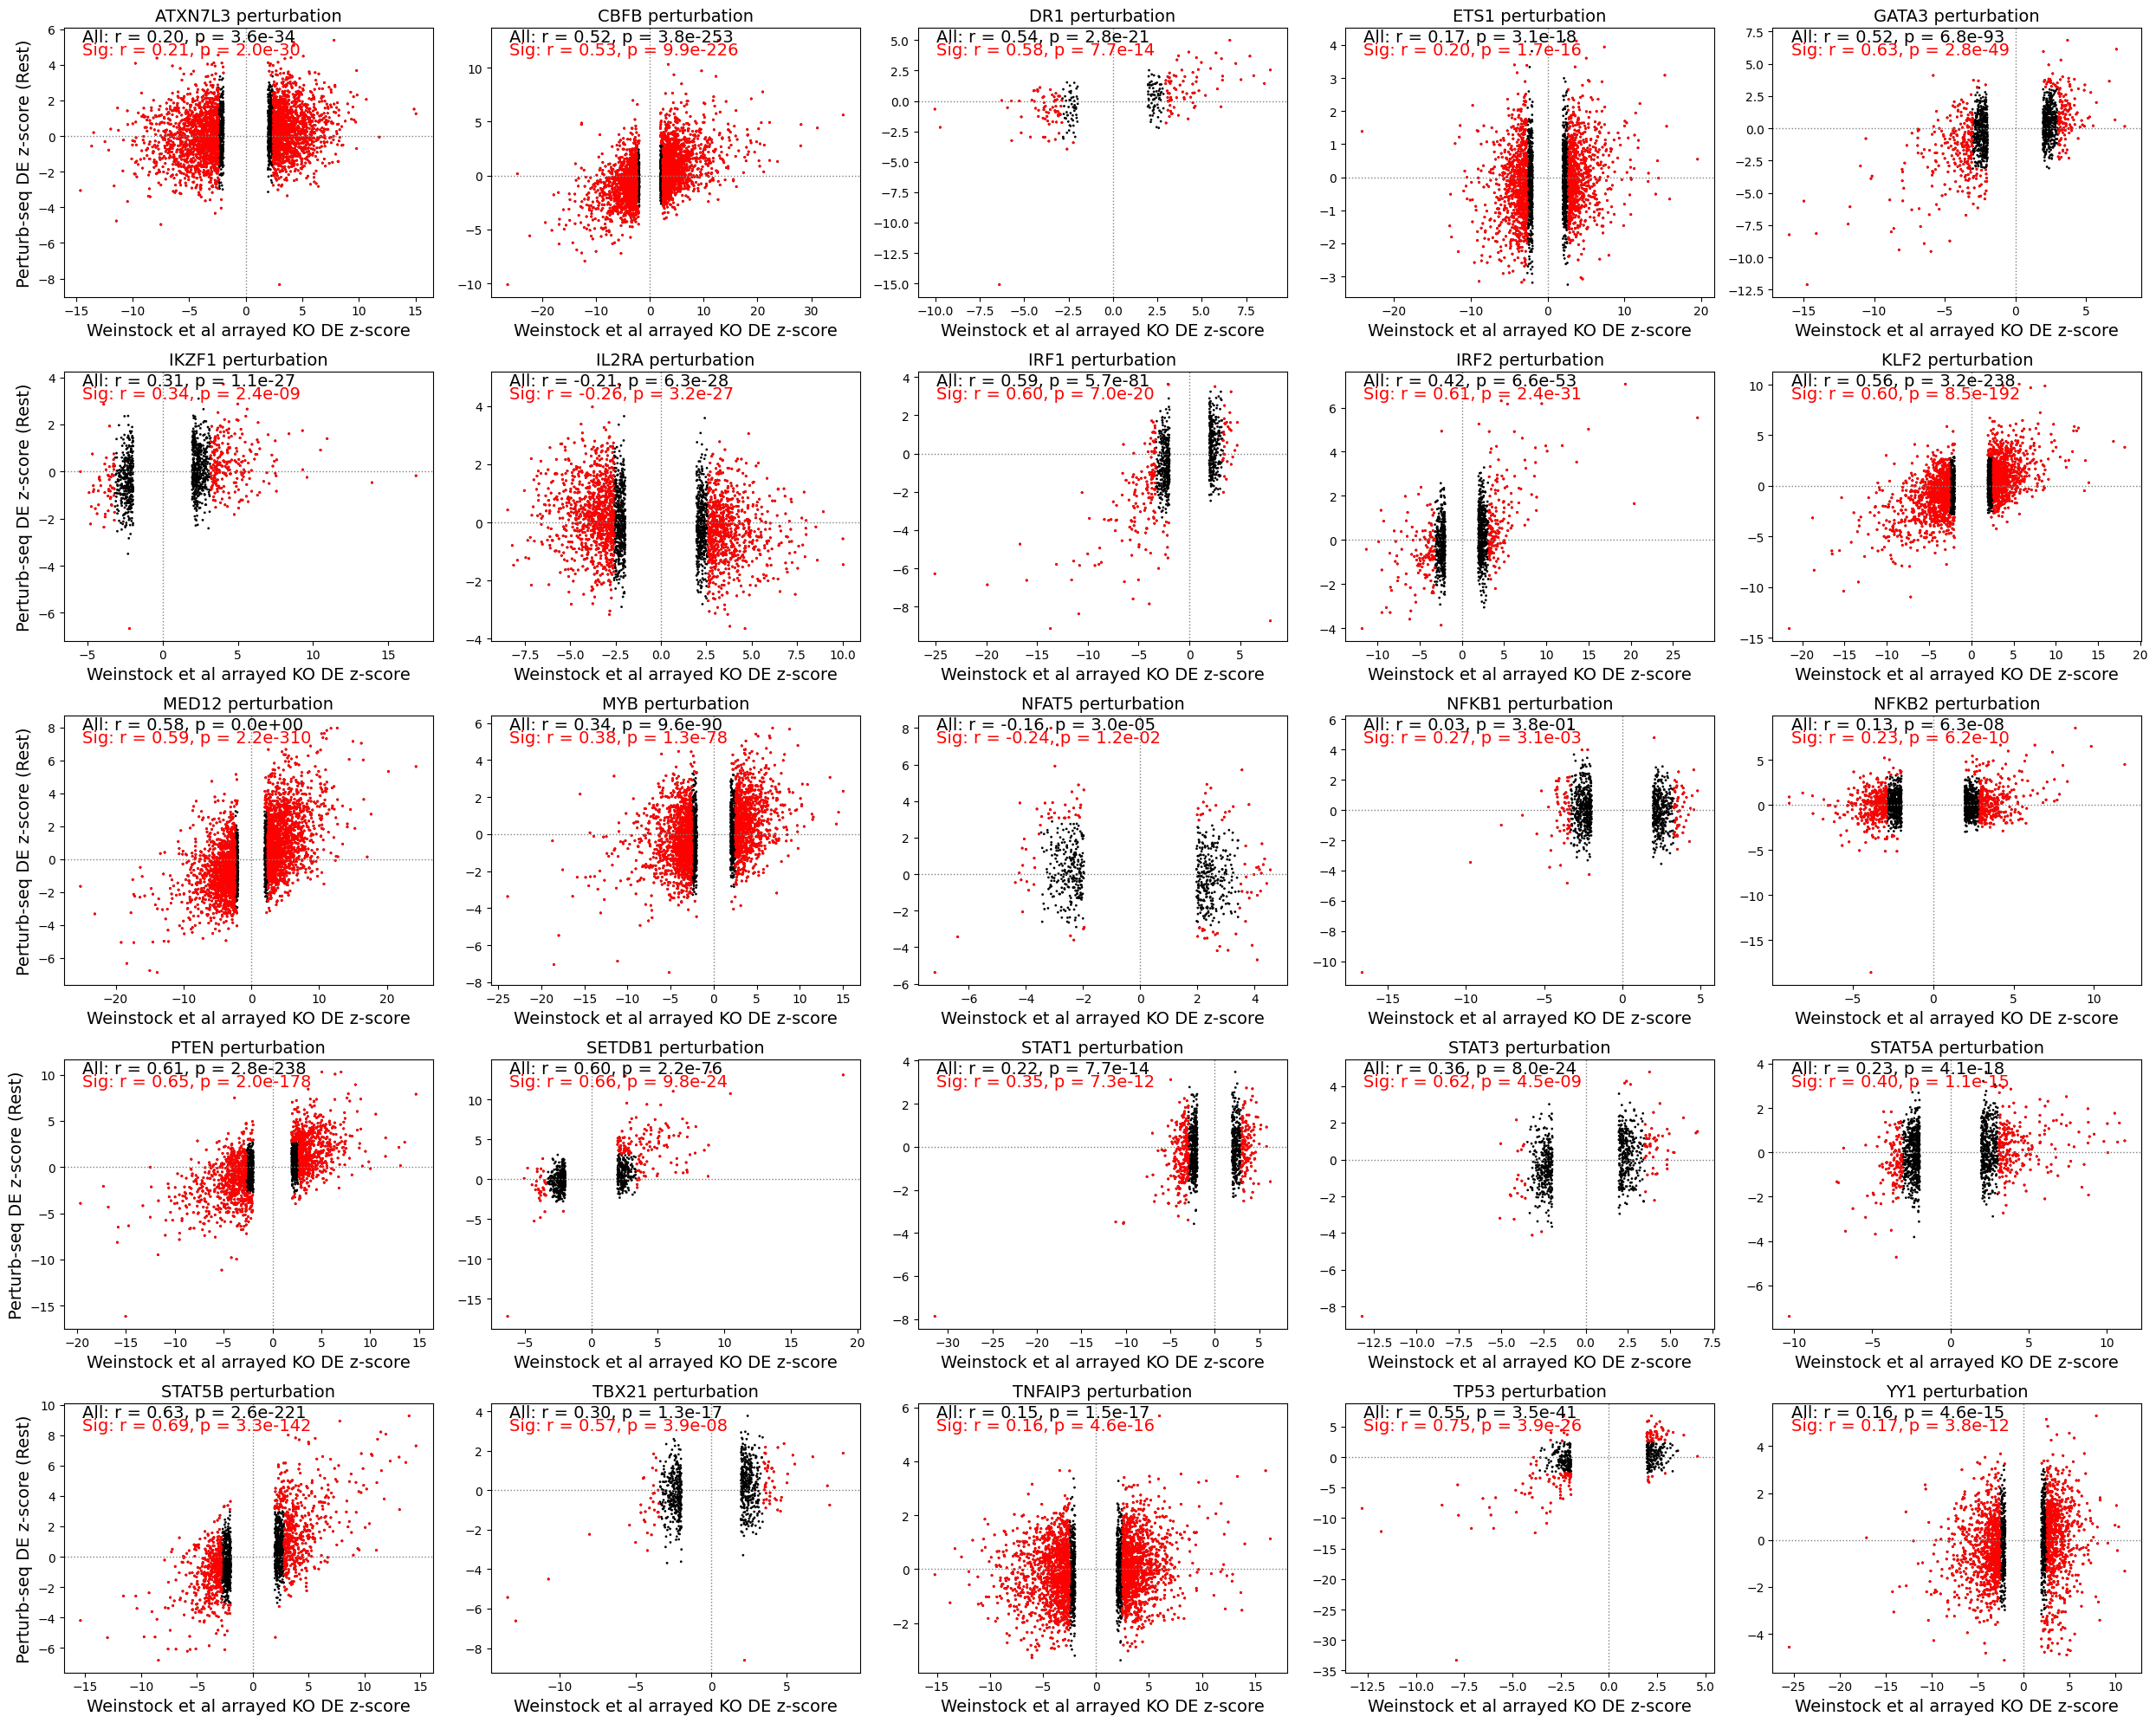

In [225]:
rest_signif_corr_all = np.zeros([len(common_sig_perturbations),2])
gwt_signif = np.zeros(len(common_sig_perturbations))
ko_signif = np.zeros(len(common_sig_perturbations))
# Calculate number of rows and columns needed
n_plots = len(common_sig_perturbations)
n_cols = 5  # Fixed number of columns
n_rows = (n_plots + n_cols - 1) // n_cols  # Ceiling division

# Create a figure with subplots arranged in multiple rows
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 4*n_rows))
axes = axes.flatten()  # Flatten to easily iterate through subplots

for i, g in enumerate(common_sig_perturbations):
    # Get data for this perturbation
    gwt_effect_g = sc.get.var_df(adata_de, adata_de.obs_names[adata_de.obs['target_contrast_gene_name'] == g].tolist(), layer='zscore')
    gwt_effect_g.columns = ['perturbseq_zscore']
    gwt_effect_g['perturbseq_signif'] = sc.get.var_df(adata_de, adata_de.obs_names[adata_de.obs['target_contrast_gene_name'] == g].tolist(), layer='adj_p_value')
    weinstock_effect_g = weinstock_df[weinstock_df['KO'] == g].set_index('gene_id')[['zscore']]
    weinstock_effect_g.columns = ['weinstock_zscore']
    weinstock_effect_g['weinstock_signif'] = weinstock_df[weinstock_df['KO'] == g].set_index('gene_id')[['padj']]

    concat_df = pd.concat([weinstock_effect_g, gwt_effect_g], axis=1).dropna()

    # Calculate correlation coefficients and p-values for Rest condition only
    rest_corr, rest_pval = scipy.stats.pearsonr(concat_df['weinstock_zscore'], concat_df['perturbseq_zscore'])
    rest_signif_corr, rest_signif_pval = scipy.stats.pearsonr(
        concat_df[(concat_df['weinstock_signif']<thre)|(concat_df['perturbseq_signif']<thre)]['weinstock_zscore'], 
        concat_df[(concat_df['weinstock_signif']<thre)|(concat_df['perturbseq_signif']<thre)]['perturbseq_zscore']
    ) if sum((concat_df['weinstock_signif']<thre)|(concat_df['perturbseq_signif']<thre)) > 1 else (float('nan'), float('nan'))

    # Create scatter plot for Rest condition
    sns.scatterplot(data=concat_df, x='weinstock_zscore', y='perturbseq_zscore', s=4, edgecolor='none', color='black', ax=axes[i])
    sns.scatterplot(data=concat_df[(concat_df['weinstock_signif']<thre)|(concat_df['perturbseq_signif']<thre)],
                    x='weinstock_zscore', y='perturbseq_zscore', s=5, edgecolor='none', color='red', ax=axes[i])

    # Add correlation information as text
    axes[i].annotate(f'All: r = {rest_corr:.2f}, p = {rest_pval:.1e}', 
                xy=(0.05, 0.95), xycoords='axes fraction', fontsize=14)
    if not np.isnan(rest_signif_corr):
        axes[i].annotate(f'Sig: r = {rest_signif_corr:.2f}, p = {rest_signif_pval:.1e}', 
                    xy=(0.05, 0.90), xycoords='axes fraction', fontsize=14, color='red')

    # Add dotted lines for x and y axes
    axes[i].axhline(y=0, color='gray', linestyle=':', linewidth=1)
    axes[i].axvline(x=0, color='gray', linestyle=':', linewidth=1)
    
    # Set title and labels
    axes[i].set_title(f'{g} perturbation', fontsize=14)
    
    # Only add y-label for plots in the first column
    if i % n_cols == 0:
        axes[i].set_ylabel('Perturb-seq DE z-score (Rest)', fontsize=14)
    else:
        axes[i].set_ylabel('')
    
    axes[i].set_xlabel('Weinstock et al arrayed KO DE z-score', fontsize=14)
    
    rest_signif_corr_all[i,0] = rest_signif_corr
    rest_signif_corr_all[i,1] = rest_signif_pval
    gwt_signif[i] = np.sum(concat_df['perturbseq_signif']<thre)
    ko_signif[i] = np.sum(concat_df['weinstock_signif']<thre)

# Hide any unused subplots
for i in range(len(common_perturbations), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

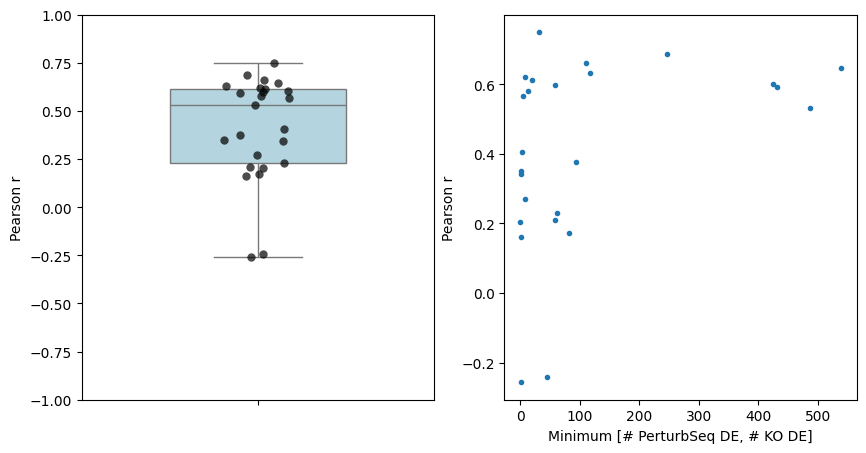

<Figure size 400x600 with 0 Axes>

In [226]:
gwt_signif = gwt_signif.astype(int)
ko_signif = ko_signif.astype(int)
num_signif = pd.DataFrame({'gwt_signif': gwt_signif, 'ko_signif': ko_signif})
# Create a simple DataFrame
df = pd.DataFrame({'r': rest_signif_corr_all[:,0], 'pvalue': rest_signif_corr_all[:,1]})

fig, ax = plt.subplots(1, 2, figsize=(10,5))
# Plot box & stripplot
plt.figure(figsize=(4, 6))
sns.boxplot(data=df, y='r', color='lightblue', width=0.5, ax=ax[0])
sns.stripplot(data=df, y='r', color='black', size=6, jitter=True, alpha=0.7, ax=ax[0])

ax[0].set_ylabel("Pearson r")
ax[0].set_ylim(-1, 1)  # since r ranges from -1 to 1

ax[1].plot(np.min(num_signif, axis=1), rest_signif_corr_all[:,0], '.')
ax[1].set_xlabel('Minimum [# PerturbSeq DE, # KO DE]')
ax[1].set_ylabel('Pearson r')

sns.despine()
plt.tight_layout()
plt.show()